# Deep Learning Usecase

## Content:
1. Working with image data in R
2. Creating deep learning architectures using the keras interface
    1. Starting with Fashion MNIST
    2. Evaluation of model output
    3. Storage and loading of models
3. Convolutional Neural Networks
4. Transfer learning with pretrained models
5. Data generators for on-the-fly preprocessing


## 1. Working with image data in R

We need a few packages
1. `keras` is an R-package interface to the Python deep learning framework keras
2. `magick` is an R-package interface to the imageMagick library for general image processing

In [1]:
library('keras')
library('magick')

Linking to ImageMagick 6.9.7.4
Enabled features: fontconfig, freetype, fftw, lcms, pango, x11
Disabled features: cairo, ghostscript, rsvg, webp


### Data provided by the keras package - Fashion MNIST

Fashion MNIST is a recently by [Zalando Research](https://github.com/zalandoresearch/fashion-mnist) published dataset containing images of 10 different clothing types. The datset is inspired by the famous MNIST dataset for handwritten digit recognition.
The dataset consists of 70K 28x28 grayscale images of fashion objects in 10 balanced categories such as bags, shoes, trousers, ...

In [2]:
# files will be stored at
# ~/.keras/datasets
fmnist = dataset_fashion_mnist()
# what does the object contain?
str(fmnist)
# 60K train and 10K test data with input X and labels y
# assign values 
x_train = fmnist$train$x
x_test = fmnist$test$x
y_train = fmnist$train$y
y_test = fmnist$test$y

List of 2
 $ train:List of 2
  ..$ x: int [1:60000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:60000(1d)] 9 0 0 3 0 2 7 2 5 5 ...
 $ test :List of 2
  ..$ x: int [1:10000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:10000(1d)] 9 2 1 1 6 1 4 6 5 7 ...


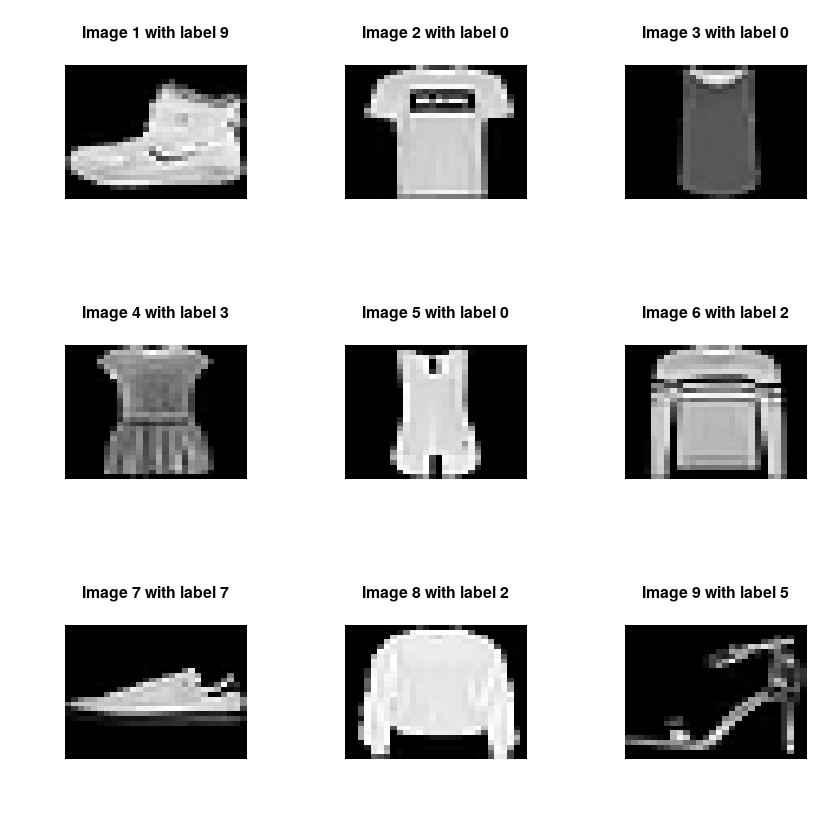

In [4]:
# inspect one train image
ids = 1:9
par(mfrow=c(3,3))
for(idx in ids) {
    foo_img = x_train[idx, , ]
    foo_label = y_train[idx]
    # plot the image with the label as header
    image(t(apply(foo_img, 2, rev)), 
        axes = FALSE, 
        col = grey(seq(0, 1, length = 256)), 
        main = paste0('Image ', idx, ' with label ', foo_label))
}


### Data provided by the keras package - CIFAR 10

Cifar10 is a [public dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html) that contains 60K 32x32 color images from 10 classes (airplanes, deer, cars, cats, ...) and is widely used for benchmarking in image classification. 

In [5]:
# Downloading the dataset can take some time as the dataset is roughly 170MB
cifar = dataset_cifar10()

In [6]:
# similar structure 
# but now with depth 3 (for red, green and blue color channels)
str(cifar)
x_train = cifar$train$x
y_train = cifar$train$y
x_test = cifar$test$x
y_test = cifar$test$y

List of 2
 $ train:List of 2
  ..$ x: int [1:50000, 1:32, 1:32, 1:3] 59 154 255 28 170 159 164 28 134 125 ...
  ..$ y: int [1:50000, 1] 6 9 9 4 1 1 2 7 8 3 ...
 $ test :List of 2
  ..$ x: int [1:10000, 1:32, 1:32, 1:3] 158 235 158 155 65 179 160 83 23 217 ...
  ..$ y: num [1:10000, 1] 3 8 8 0 6 6 1 6 3 1 ...


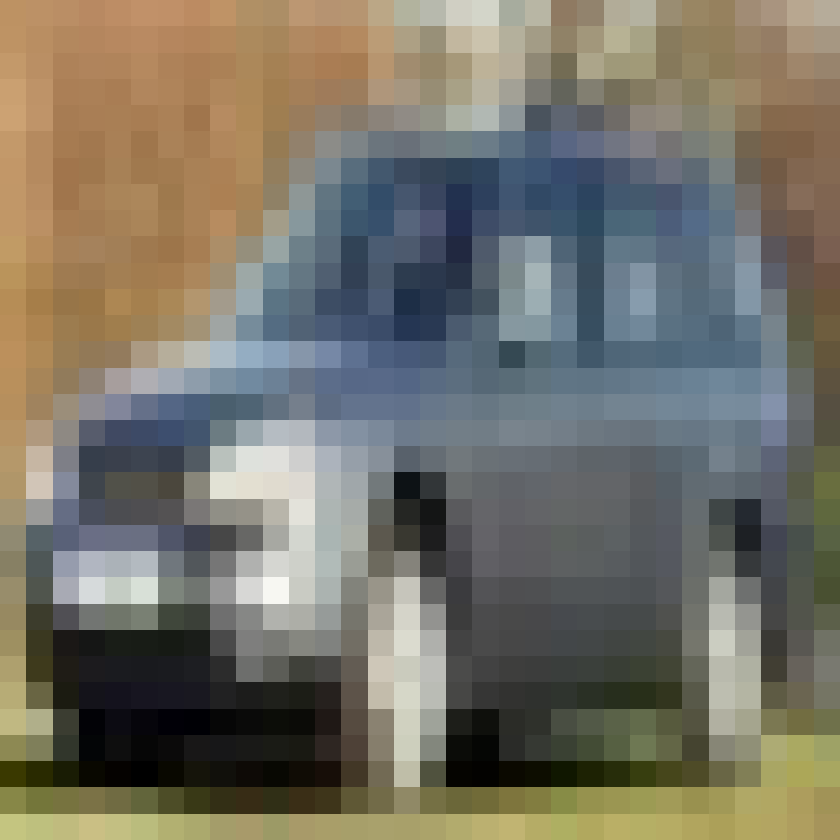

In [7]:
# inspect one train image
# consists of 3 matrices of RGB integers in {0, ..., 255}
idx = 177
foo_img = x_train[idx, , ,]
foo_label = y_train[idx]

# plot the images with grid package
# therefore, pixels have to be squashed to [0, 1]
r = foo_img[ , , 1] / 255
g = foo_img[ , , 2] / 255
b = foo_img[ , , 3] / 255
col <- rgb(r, g, b)
dim(col) <- dim(r)
grid::grid.raster(col, interpolate=FALSE)

## Load and manipulate your own image data

In real applications we need to load and preprocess raw images.
As an example we load an test image into R. The R package [magick](https://cran.r-project.org/web/packages/magick/vignettes/intro.html#installing_magick) offers very comprehensive image manipulation methods in a unified framework.

In [8]:
# install.packages('magick')
# read the image
data_path = 'data/lenna.jpg'
img = image_read(path = data_path)


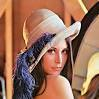

  format width height colorspace matte filesize density
1   JPEG    99     99       sRGB FALSE     3331   72x72

In [9]:
# plot the image
img

In [21]:
# extract raw pixel data from the image object
img_data = as.integer(image_data(img))
# dimension of the image
dim(img_data)
# some elements of the image
img_data[25:30, 40:45, 1]
# values should lie in the range {0, ..., 255}
range(img_data)

[1] 99 99  3

227,219,216,212,208,207
218,207,208,212,216,218
204,203,207,212,219,220
194,211,212,214,213,209
196,205,210,216,212,205
200,190,200,211,214,210


[1]   0 255

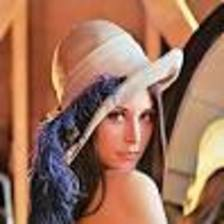

  format width height colorspace matte filesize density
1   JPEG   224    224       sRGB FALSE        0   72x72

In [10]:
# resize the image in case they have different formats
# e.g. Resnet takes 224x224 images as input
resized_img = magick::image_resize(image = img, geometry = "224x224")
resized_img

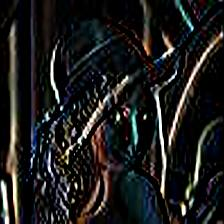

  format width height colorspace matte filesize density
1   JPEG   224    224       sRGB FALSE        0   72x72

In [11]:
# Convolve over the image with a Sobel filter to detect edges
image_convolve(resized_img, 'Sobel')

## 2. Getting started with Keras for modeling

Running and training neural networks with keras consists of the following steps:

1. Reading and splitting data
2. Defininig the architecture of the model
3. Setting hyperparameters and train the model 
4. Evaluation of the model performance


In the following, we will train different model architectures on the task to classifiy the Fashion MNIST images in their 10 categories.


### 2.1 Reading and preparing the data

In [12]:
# read the data
fmnist = dataset_fashion_mnist()
# assign values 
x_train = fmnist$train$x
x_test = fmnist$test$x
y_train = fmnist$train$y
y_test = fmnist$test$y
# dictionary for translation of the labels to meaningful category names
label_dict = cbind(c('tshirt', 'trouser', 'pullover', 'dress', 'coat', 
                     'sandal', 'shirt', 'sneaker', 'bag', 'ankleboot'), 
                   0:9)
label_dict

tshirt,0
trouser,1
pullover,2
dress,3
coat,4
sandal,5
shirt,6
sneaker,7
bag,8
ankleboot,9


In [13]:
dim(x_train)

[1] 60000    28    28

In [14]:
# convert the labels to categorical one-hot-encoded vectors
# store the real value as well and translate them into meaningful classes
y_train_noncateg = cbind(y_train, label_dict[match(y_train, label_dict[, 2]), 1])
y_test_noncateg = cbind(y_test, label_dict[match(y_test, label_dict[, 2]), 1])
y_train = to_categorical(y = y_train)
y_test = to_categorical(y = y_test)

head(y_train)

# flatten the data input arrays from 60K 28x28 matrix to 60K 784 vector format
x_train = array_reshape(x_train, c(nrow(x_train), 28*28))
x_test = array_reshape(x_test, c(nrow(x_test), 28*28))

0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0


### 2.2 Defining the architecture - Sequential

Training a model with keras is done in three steps

1. Define architecture
2. Compile model with `compile`
3. Train the model with `fit`



As an initial model we create a fully connected neural network of three hidden layers of size 128, 64 and 32. We use the __sequential architecture__ which allows to stack layers upon each other using the __pipe operator__ `%>%`.


In [15]:
# define and instantiate the sequential model type
model_seq = keras_model_sequential() 

# build the model layer-wise with the pipe operator %>%
model_seq %>% 
    # input the data as vectors of length 28x28 = 784
    # define the three hidden layers with relu activation and (128, 64, 32) neurons per layer
    layer_dense(units = 128, activation = 'relu', input_shape = 784) %>% 
    layer_dense(units = 64, activation = 'relu') %>%
    layer_dense(units = 32, activation = 'relu') %>%
    # add softmax as activation for the last layer as we want to output probality 
    # scores in [0, 1] for the 10 classes
    layer_dense(units = 10, activation = 'softmax')


In [16]:
# summary() allows us to check the architecture
# for instance, the 3rd layer contains 2080 = 64*32 + 32 weight parameters, as 32 neurons are connected
# with the output from the preceeding 64 neurons and are each combined with a bias factor
summary(model_seq)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 128)                     100480      
________________________________________________________________________________
dense_2 (Dense)                     (None, 64)                      8256        
________________________________________________________________________________
dense_3 (Dense)                     (None, 32)                      2080        
________________________________________________________________________________
dense_4 (Dense)                     (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
________________________________________________________________________________


### 2.3 Compiling and running the model 

We choose the categorical cross entropy loss to optimize and stochastic gradient descent with momentum as the optimizer and measure accuracy in the training process.
Check the CRAN documentation for more information on available losses, optimizers and metrics. 
This step defines the computational graph that is exectuted in the next step

In [17]:
compile(model_seq,
  loss = 'categorical_crossentropy',
  optimizer = optimizer_sgd(lr = 0.0001, momentum = 0.9),
  metrics = c('accuracy')
)

In [18]:
# train the compiled model with the fit function and save the training progress in the history variable
history = fit(model_seq,
    x_train, y_train, 
    epochs = 10, batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1)

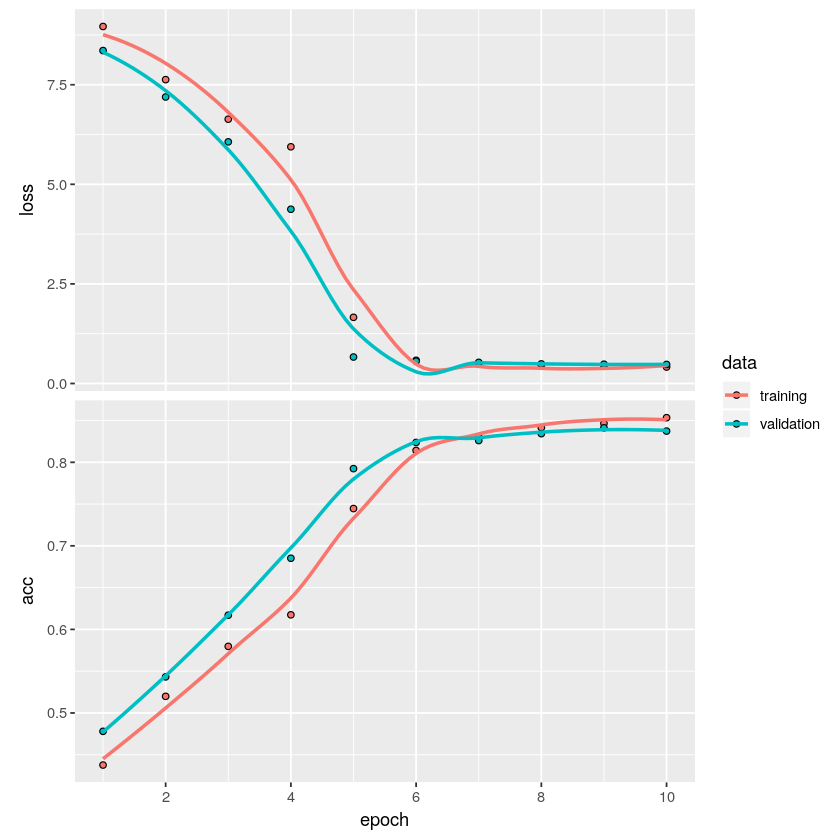

In [19]:
# inspect the train and validation history
plot(history)

### 2.4 Predictions and performance evaluation

In [20]:
# get the test performance of the trained model
test_perf = evaluate(model_seq, x_test, y_test)
test_perf

$loss
[1] 0.502

$acc
[1] 0.8268

In [21]:
# make hard predictions on all our test data
preds = predict_classes(model_seq, x_test)
pred_frame = data.frame(factor(preds, as.character(0:9)), 
                        label_dict[match(preds, label_dict[, 2]), 1], 
                        y_test_noncateg)
colnames(pred_frame) = c('yhat', 'yhat_label', 'y', 'y_label')
head(pred_frame)

yhat,yhat_label,y,y_label
9,ankleboot,9,ankleboot
2,pullover,2,pullover
1,trouser,1,trouser
1,trouser,1,trouser
6,shirt,6,shirt
1,trouser,1,trouser


In [22]:
# make soft predictions (softmax) on all our test data
preds = predict_proba(model_seq, x_test)
soft_pred_frame = cbind(preds, y_test_noncateg)
colnames(soft_pred_frame) = c(paste0('yhat_class_', c(0:9)), 'y', 'y_label')
head(soft_pred_frame)

yhat_class_0,yhat_class_1,yhat_class_2,yhat_class_3,yhat_class_4,yhat_class_5,yhat_class_6,yhat_class_7,yhat_class_8,yhat_class_9,y,y_label
2.24854530848429e-15,0.000155983463628218,5.87730330983e-13,2.55758735452074e-14,1.2030009211017e-09,0.00445560459047556,2.08108134674631e-14,0.0547767877578735,9.6599762855476e-07,0.940610587596893,9,ankleboot
0.00383115676231682,4.6886388001266e-13,0.776016116142273,0.00000279850928563974,0.00360167236067355,6.55405131055886e-07,0.216543272137642,4.64379576459173e-11,0.00000438205961472704,1.72650213570158e-10,2,pullover
0,1,0,5.40996186568703e-26,0,1.35417599216084e-28,1.96930843489665e-27,8.74329483899252e-34,3.42982512777374e-38,1.16830137720959e-17,1,trouser
0,1,0,0,0,0,0,0,0,0,1,trouser
0.331288367509842,0.000286803173366934,0.145924940705299,0.0160116218030453,0.0327805392444134,0.00136159418616444,0.419700652360916,0.00050869258120656,0.0520226247608662,0.000114221438707318,6,shirt
2.21484107341965e-16,0.99999988079071,3.17592719547497e-26,3.87015290925774e-08,5.54781814384328e-24,5.97499480448072e-13,4.04579064694488e-10,2.12556479029386e-19,2.42033904853875e-14,1.76298129872521e-07,1,trouser


#### Confusion matrix

In [25]:
conf_frame = table(pred_frame$y, pred_frame$yhat)
colnames(conf_frame) = label_dict[, 1]
rownames(conf_frame) = label_dict[, 1]
as.data.frame.matrix(conf_frame)

,tshirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,ankleboot
tshirt,839,3,8,16,2,1,120,0,10,1
trouser,8,954,2,22,2,0,7,0,5,0
pullover,22,3,712,10,92,1,149,0,11,0
dress,98,17,2,769,41,1,65,0,7,0
coat,1,1,129,30,669,0,165,0,5,0
sandal,2,0,2,1,0,909,1,56,8,21
shirt,201,1,92,12,61,0,618,0,15,0
sneaker,0,0,0,0,1,24,0,925,4,46
bag,8,1,6,5,3,3,32,4,938,0
ankleboot,0,0,0,0,1,16,0,47,1,935


#### Saving and loading the model weights

To save a model to the hard drive for late use the [hdf5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) data format is widely used.

In [26]:
# save model weights and architecture to hdf5 file
save_model_hdf5(object =  model_seq, filepath = 'model_fashionmnist_fully_connected.h5')

In [27]:
# load model with a new name 
loaded_model = load_model_hdf5(filepath = 'model_fashionmnist_fully_connected.h5')
# check the architecture 
summary(loaded_model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 128)                     100480      
________________________________________________________________________________
dense_2 (Dense)                     (None, 64)                      8256        
________________________________________________________________________________
dense_3 (Dense)                     (None, 32)                      2080        
________________________________________________________________________________
dense_4 (Dense)                     (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
________________________________________________________________________________


In [28]:
# test performance of the loaded model on the same test data
evaluate(loaded_model, x_test, y_test)

$loss
[1] 0.502

$acc
[1] 0.8268

## 3. Convolutional Neural Networks

Up until now each image was treated as a vector of integers of size 28x28=784 and fed into the fully-connected neural network. 

We would like to use the spatial information of the image, i.e., if pixels are close together or far away.
To achieve this we use __convolutional layers__ in our network.

The basic layout of a convolutional layer can be seen here:
![](data/cnn11.png)

In [2]:
# define and instantiate the sequential model type
model_conv = keras_model_sequential() 

model_conv %>% 
    layer_conv_2d(filters = 20, kernel_size = c(5, 5), activation = 'relu', 
                 padding = 'same', input_shape = c(28, 28, 1)) %>% 
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2,2)) %>% 
    layer_conv_2d(filters = 50, kernel_size = c(5, 5), activation = 'relu', 
                 padding = 'same') %>% 
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2,2)) %>% 
    layer_flatten() %>% 
    layer_dense(units = 500, activation = 'relu') %>% 
    layer_dense(units = 10, activation = 'softmax')

# compile the model 
compile(model_conv,
  loss = 'categorical_crossentropy',
  optimizer = optimizer_sgd(lr = 0.00005, momentum = 0.9),
  metrics = c('accuracy')
)

# check the model architecture
summary(model_conv)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 28, 28, 20)              520         
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 14, 14, 20)              0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 14, 14, 50)              25050       
________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)      (None, 7, 7, 50)                0           
________________________________________________________________________________
flatten_1 (Flatten)                 (None, 2450)                    0           
________________________________________________________________________________
dense_1 (Dense)             

In [3]:
# get the data in 28x28 format
fmnist = dataset_fashion_mnist()
x_train = fmnist$train$x
x_test = fmnist$test$x
y_train = fmnist$train$y
y_test = fmnist$test$y

# reshape the array to dimension (#data, Xdim, Ydim, #channels)
x_train = array(x_train, c(60000, 28, 28, 1))
x_test = array(x_test, c(10000, 28, 28, 1))

# check the dimensionality of each of the 60K train images
dim(x_train)
# one-hot encode the labels
y_train = to_categorical(y = y_train)
y_test = to_categorical(y = y_test)


[1] 60000    28    28     1

In [4]:
# train the compiled model with the fit function
# save the training progress in the history file
history = fit(model_conv,
    x = x_train, 
    y = y_train, 
    epochs = 10, 
    batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1
)

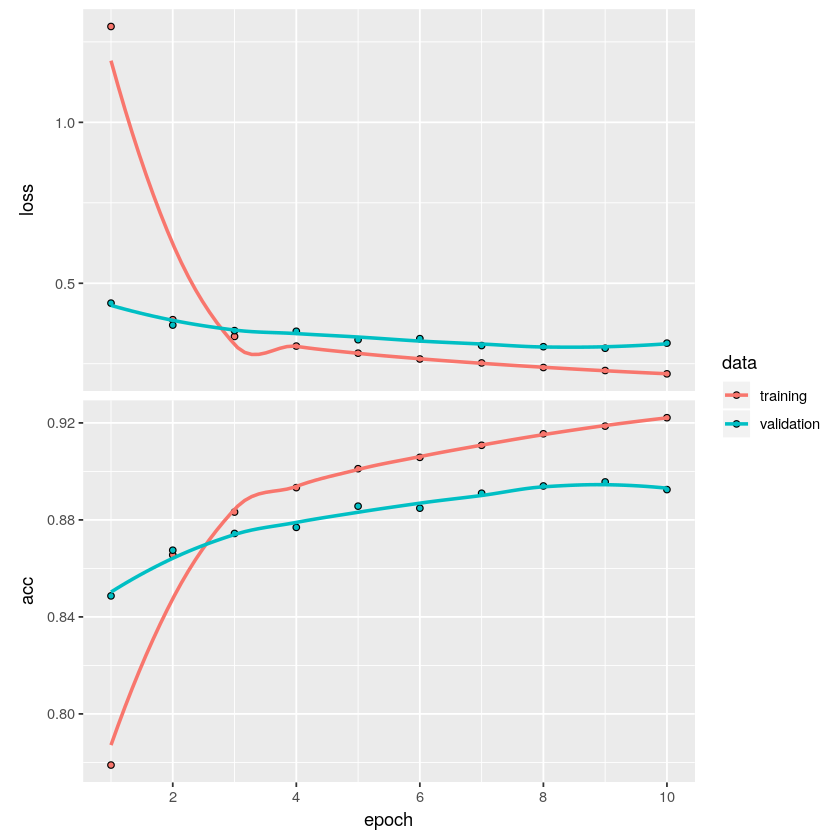

In [5]:
plot(history)

In [6]:
# evaluate the performance
evaluate(model_conv, x_test, y_test)

$loss
[1] 0.3277

$acc
[1] 0.8867

# 4. Transfer Learning: working with pre-trained models

In real-world applications, the amount of labeled training data is often limited. As the performance of deep learning models is highly dependent on vast amounts of data, methods to overcome this problem are developed. 
One possibility is __transfer learning__.

The basic idea of transfer learning is to train a model on a rich, labeled dataset that is related to the task of interest and then fine-tune this model on the small amount of labeled data of actual task. 

One example for a large, labeled and public data set is [ImageNet](http://www.image-net.org/) provided by Stanford University, which contains over 14 million images for 1000 classes. 

We will 

1. Download and use a pretrained model to classifiy a new image
2. Fine-tune the pre-trained model on new data

## 4.1. Use a pretrained net for classification 

We use the a pretrained Resnet50 architecture to classify a new, image, the picture of a cow. 
The Resnet was trained on color images with the dimension (xdim = 224, ydim = 224, color channels = 3), thus we have to preprocess the images to the same dimensions. 

### 5.1.1 Cow detection 

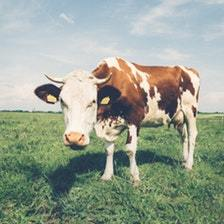

  format width height colorspace matte filesize density
1   JPEG   224    224       sRGB FALSE        0   72x72

[1]   1 224 224   3

In [7]:
# get the image
# magick package
cow = image_read(path = "data/cow.jpg")
cow = magick::image_resize(image = cow, geometry = "224x224")
cow
# get the data
cow_data = as.integer(image_data(cow))
# add 4th dimension such that the resulting array has dim
# (batch size, xdim, ydim, channel size)
cow_data = array(cow_data, c(1, 224, 224, 3))
dim(cow_data)

In [8]:
# get the pretrained model from the keras library
# load the weights from the folder of this Repository
# we already downloaded the weights to this location for you
model_pretrained = application_resnet50(weights = "models/resnet50_weights_tf_dim_ordering_tf_kernels.h5")

In [9]:
# The ResNet50 architecture, that we now use as a classifier for the cow and the dished, is a 
# lot more advanced than the simple CNN that we build earlier. Let us take a look at the architecture:
summary(model_pretrained)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      (None, 224, 224,  0                                   
________________________________________________________________________________
conv1_pad (ZeroPadding2D) (None, 230, 230,  0        input_1[0][0]              
________________________________________________________________________________
conv1 (Conv2D)            (None, 112, 112,  9472     conv1_pad[0][0]            
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 112, 112,  256      conv1[0][0]                
________________________________________________________________________________
activation_1 (Activation) (None, 112, 112,  0        bn_conv1[0][0]             
________________________________________________________________________________
max_pooling2d_3 (MaxPooli (N

In [10]:
# run the model to make the prediction 
prediction = predict(model_pretrained, cow_data)

In [11]:
# check the predicted classes with the top 5 highest scores
imagenet_decode_predictions(preds = prediction, top = 5)[1]

class_name,class_description,score
n02403003,ox,0.9167069
n03868242,oxcart,0.0811728
n02408429,water_buffalo,0.0007267
n03967562,plow,0.0007090
n02412080,ram,0.0002271


## 4.2. Fine-tune a pretrained net on a new task

We gathered a data set of 150 images of chicago buildings and 250 ancient egyptian buildings from [Wikicommons](https://commons.wikimedia.org/wiki/Hauptseite) provided by [researcher Zhe Xu](https://sites.google.com/site/zhexuutssjtu/projects/arch). 

We want to predict the type of architecture from images of buildings, which could be used to price insurance premiums.  

Our data set is too small to train a deep convolutional neural network for this task from scratch. Thus, we use the previous pretrained ResNet50 which was trained on ImageNet and fine tune it on our specific task.

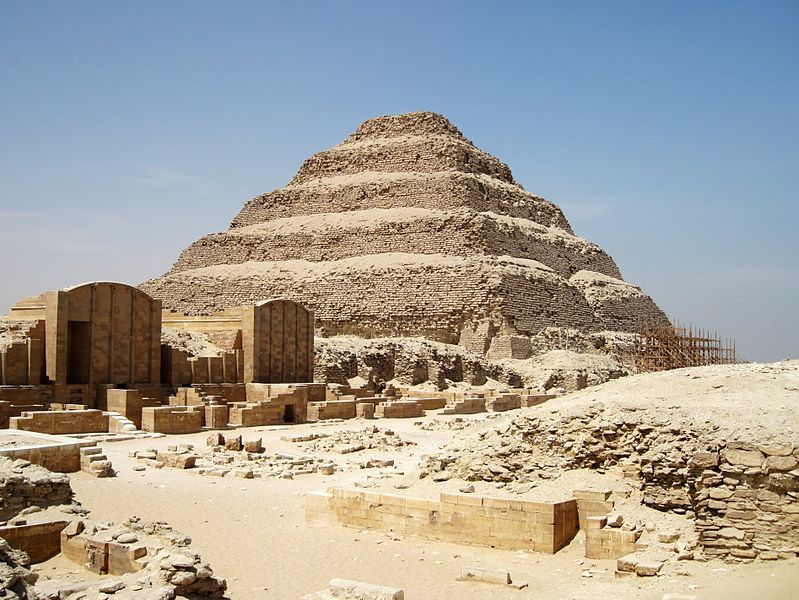

  format width height colorspace matte filesize density
1   JPEG   799    600       sRGB FALSE   118120 180x180

In [13]:
# example image of ancient egyptian building
egyptian = image_read(path = "data/arch_data/train/egypt/egypt1.jpg")
egyptian

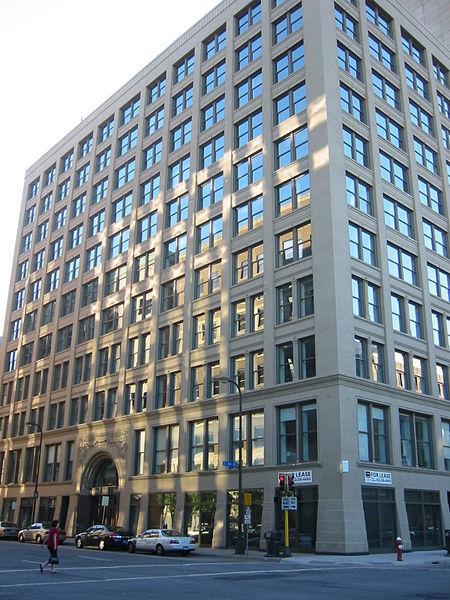

  format width height colorspace matte filesize density
1   JPEG   450    600       sRGB FALSE    87771 180x180

In [14]:
# example image of building from chicago
chicago = image_read(path = 'data/arch_data/train/chicago/chicago1.jpg')
chicago

In [15]:
# get the train data file paths
train_paths_chicago = paste0('data/arch_data/train/chicago/', list.files('data/arch_data/train/chicago/'))
train_paths_egypt = paste0('data/arch_data/train/egypt/', list.files('data/arch_data/train/egypt/'))
all_train_paths = c(train_paths_chicago, train_paths_egypt)
amount_train_data = length(train_paths_chicago) + length(train_paths_egypt)
# how many train images do we have?
amount_train_data

[1] 325

In [16]:
# instantiate X_train array with rgb images 
X_train = array(0, c(amount_train_data, 3, 224, 224))
for(i in 1:amount_train_data){
    # read, and resize image
    img = magick::image_resize(image = magick::image_read(path = all_train_paths[i]), geometry = "224x224!")
    X_train[i, , , ] = as.integer(magick::image_data(img))
}
# permute axis to (#images, yaxis, xaxis, #channels)
X_train = aperm(X_train, c(1, 3, 4, 2))

y_train = array(c(rep(0, length(train_paths_chicago)), rep(1, length(train_paths_egypt))), c(325, 1))
dim(X_train)

[1] 325 224 224   3

In [17]:
# get the test data file paths
test_paths_chicago = paste0('data/arch_data/validation/chicago/', list.files('data/arch_data/validation/chicago/'))
test_paths_egypt = paste0('data/arch_data/validation/egypt/', list.files('data/arch_data/validation/egypt/'))
all_test_paths = c(test_paths_chicago, test_paths_egypt)
amount_test_data = length(test_paths_chicago) + length(test_paths_egypt)
# how many test images do we have?
amount_test_data

[1] 73

In [18]:
# instantiate X_test array with rgb images 
X_test = array(0, c(amount_test_data, 3, 224, 224))
for(i in 1:amount_test_data){
    # read, and resize image
    img = magick::image_resize(image = magick::image_read(path = all_test_paths[i]), geometry = "224x224!")
    X_test[i, , , ] = as.integer(magick::image_data(img))
}
# permute axis to (#images, yaxis, xaxis, #channels)
X_test = aperm(X_test, c(1, 3, 4, 2))

y_test = array(c(rep(0, length(test_paths_chicago)), rep(1, length(test_paths_egypt))), c(amount_test_data, 1))
dim(X_test)

[1]  73 224 224   3

In [19]:
# what is the label distribution?
# 125 chicago images and 200 egypt images for training 
table(y_train)
# 19 chicago and 54 egypt images for testing
table(y_test)

y_train
  0   1 
125 200 

y_test
 0  1 
19 54 

#### Build and train the model

In [20]:
# we use the pretrained Resnet and 'cut off its head' 
# and add two fully connected layers which we will fine-tune.
# Important: specify the input shape first the weights are already a part of this repo, 
# more details on additional, pretrained architectures can be found in the sources at the end of the notebook
input_tensor = layer_input(shape = c(224, 224, 3))
base_model = application_resnet50(input_tensor = input_tensor,
    weights = "models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5", 
    include_top = FALSE)

In [21]:
summary(base_model)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_2 (InputLayer)      (None, 224, 224,  0                                   
________________________________________________________________________________
conv1_pad (ZeroPadding2D) (None, 230, 230,  0        input_2[0][0]              
________________________________________________________________________________
conv1 (Conv2D)            (None, 112, 112,  9472     conv1_pad[0][0]            
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 112, 112,  256      conv1[0][0]                
________________________________________________________________________________
activation_50 (Activation (None, 112, 112,  0        bn_conv1[0][0]             
________________________________________________________________________________
max_pooling2d_4 (MaxPooli (N

In [22]:
# add our custom layers
ext_model = base_model$output %>% 
    layer_flatten() %>% 
    layer_dense(units = 64, activation = 'relu') %>% 
    layer_dense(units = 1, activation = 'sigmoid')

# this is the model we will train
model = keras_model(inputs = base_model$input, outputs = ext_model)

# train only the top layers 
# freeze all layers from the ResNet50
freeze_weights(model, from = 1, to = 174)

In [23]:
summary(model)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_2 (InputLayer)      (None, 224, 224,  0                                   
________________________________________________________________________________
conv1_pad (ZeroPadding2D) (None, 230, 230,  0        input_2[0][0]              
________________________________________________________________________________
conv1 (Conv2D)            (None, 112, 112,  9472     conv1_pad[0][0]            
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 112, 112,  256      conv1[0][0]                
________________________________________________________________________________
activation_50 (Activation (None, 112, 112,  0        bn_conv1[0][0]             
________________________________________________________________________________
max_pooling2d_4 (MaxPooli (N

In [55]:
# binary task -> binary cross entropy loss
compile(model,
        optimizer = optimizer_sgd(lr = 0.00001, momentum = 0.6), 
        loss = 'binary_crossentropy', 
        metrics = c('accuracy'))

In [56]:
history = fit(model,
    x = X_train, 
    y = y_train, 
    epochs = 1, 
    batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1
)

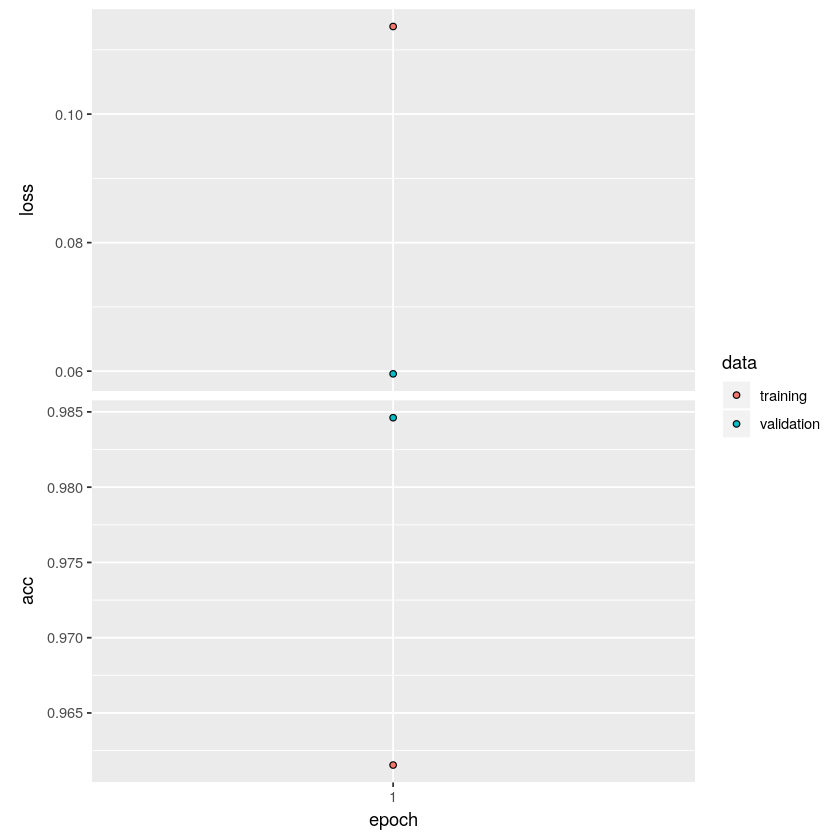

In [57]:
plot(history)

#### Evaluate performance

In [58]:
# evaluate the performance on the test data
evaluate(model, X_test, y_test)

$loss
[1] 0.2968

$acc
[1] 0.8493

In [59]:
# make predictions on all our test data
preds = predict(model, X_test)

In [60]:
# set threshold to 0.5 to yield hard predictions
# what would be a better way to yield a reasonable threshold?
yhat = ifelse(preds > 0.5, 1, 0)
pred_frame = as.data.frame(cbind(preds, yhat, y_test))
colnames(pred_frame) = c('prob', 'yhat', 'y_test')
head(pred_frame)

prob,yhat,y_test
0.36997,0,0
0.59878,1,0
0.58799,1,0
0.77800,1,0
0.01727,0,0
0.62366,1,0


In [61]:
# simple accuracy 
# important note: not taking into account the unbalancedness of the test data
acc = sum(pred_frame$yhat == pred_frame$y_test) / nrow(pred_frame)
acc

[1] 0.8493

In [62]:
conf_frame = table(pred_frame$yhat, pred_frame$y_test)
colnames(conf_frame) = c('chicago', 'egypt')
rownames(conf_frame) = c('chicago', 'egypt')

In [63]:
# inspect the confusion matrix
# rows represent the predicted values and columns represent the true values
# a perfect confusion matrix contains only non-zero values on the diagonal 
# how can we interpret those results?
# what would be next steps for troubleshooting?
conf_frame

         
          chicago egypt
  chicago       8     0
  egypt        11    54

#### Check the missclassified images

For troubleshooting, we check those images that were missclassified by the model.

In [65]:
# indices of the missclassified chicago buildings
miss_chicago = which(pred_frame$yhat != pred_frame$y_test & pred_frame$y_test == 0)
miss_chicago

[1]  2  3  4  6 10 11 14 15 16 17 19

In [66]:
# indices of the missclassified egypt buildings
miss_egypt = which(pred_frame$yhat != pred_frame$y_test & pred_frame$y_test == 1)
miss_egypt

integer(0)

,prob,yhat,y_test
2,0.5988,1,0
3,0.5880,1,0
4,0.7780,1,0
6,0.6237,1,0
10,0.6328,1,0
11,0.6718,1,0
14,0.9707,1,0
15,0.8087,1,0
16,0.5860,1,0
17,0.9071,1,0


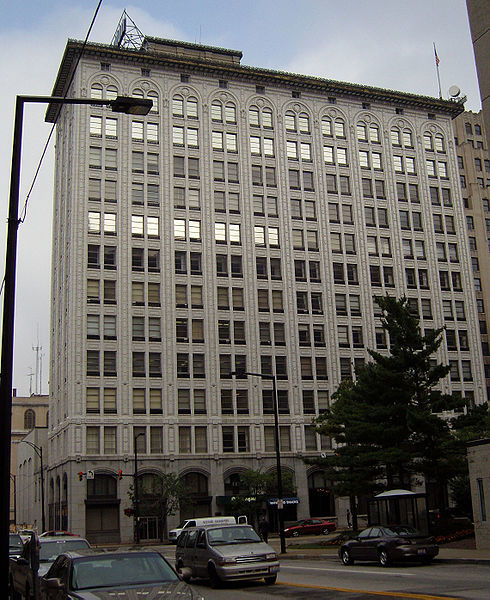

  format width height colorspace matte filesize density
1   JPEG   490    600       sRGB FALSE    99868   72x72

In [67]:
# probability scores for the missclassified samples to be part of class egyptian 
# p(y = 1|X)
# it is interesting to see, that despite of sample 10 it was a close decision for the net
# maybe, the color structure of image 10 is similar to an ancient egyptian building?
pred_frame[miss_chicago, ]
# show the third missclassified chicago image
miss_chicago_image = image_read(path = paste0('./data/arch_data/train/chicago/chicago', miss_chicago[3], '.jpg'))
miss_chicago_image

## 5. Data Generator

One problem in deep learning, especially when the amounts of data gets large, is that the whole data set does not fit in memory. A way to overcome this limitation is the usage of a __data generator__. 
This is an object, that loads batches of data on-the-fly during the batch-wise training process. 

Additionally, __data augmentation__ techniques can be used by the data gernerator. Each image is getting shifted/rotated/cropped randomly, such that the meaning of the image does not change (a flipped t-shirt is still a t-shirt which also holds for ancient egypt pyramids). This way, the dataset size artificially increased which helps to improve model performance. 

Keras makes it straightforward to implement such a data generator. 
We continue on the architecture-detection problem. 

In [83]:
# define a data generator that handles the preprocessing/ augmentation of each 
# single image
# here, we only do vertical flipping
# check the docu for the full set of possible augmentation techniques
data_generator_train = image_data_generator(
    horizontal_flip = FALSE,
    vertical_flip = TRUE)

# we do not apply any augmentation on the validation data
data_generator_validation = image_data_generator(
    horizontal_flip = FALSE,
    vertical_flip = FALSE)

The function `flow_images_from_directory()` creates a data generator from images stored in a given path. 
Therefore, the data should follow such a folder structure:
* data  
    * train
        * classname 0
            *  classname0_1.jpg
            *  classname0_2.jpg
            *  ...
        * classname 1
        * ...
    * validation 
        * classname 0
        * classname 1
        * ...
    
Given this folder structure, the function will determine the amount of classes and images by itself. For an example, check the folder `./data/arch_data/` in this repository.

In [91]:
train_generator = flow_images_from_directory(
    directory = './data/arch_data/train/', 
    generator = data_generator_train, 
    target_size = c(224, 224), 
    classes = c('chicago', 'egypt'),
    class_mode = "binary",
    color_mode = 'rgb',
    batch_size = 32,
    shuffle = TRUE
)
validation_generator = flow_images_from_directory(
    directory = './data/arch_data/validation/', 
    generator = data_generator_validation, 
    target_size = c(224, 224),
    classes = c('chicago', 'egypt'),
    class_mode = "binary",
    color_mode = 'rgb',
    batch_size = 32, 
    shuffle = FALSE
)

In [92]:
input_tensor = layer_input(shape = c(224, 224, 3))
base_model = application_resnet50(input_tensor = input_tensor,
    weights = './models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    include_top = FALSE)

In [93]:
# add our custom layers
ext_model = base_model$output %>% 
    layer_flatten() %>% 
    layer_dense(units = 64, activation = 'relu') %>% 
    layer_dense(units = 1, activation = 'sigmoid')

# this is the model we will train
model_gen = keras_model(inputs = base_model$input, outputs = ext_model)

In [94]:
# train only the top layers 
# freeze all layers from the ResNet50
freeze_weights(model_gen, from = 1, to = 174)
compile(model_gen, 
        optimizer = optimizer_sgd(lr = 0.0001, momentum = 0.9), 
        loss = 'binary_crossentropy', 
        metrics = c('accuracy'))

In [95]:
# check the architecture of this massive model
# special attention: 'only' a fraction of the 24Mio parameters will be fine-tuned
summary(model_gen)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_6 (InputLayer)      (None, 224, 224,  0                                   
________________________________________________________________________________
conv1_pad (ZeroPadding2D) (None, 230, 230,  0        input_6[0][0]              
________________________________________________________________________________
conv1 (Conv2D)            (None, 112, 112,  9472     conv1_pad[0][0]            
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 112, 112,  256      conv1[0][0]                
________________________________________________________________________________
activation_246 (Activatio (None, 112, 112,  0        bn_conv1[0][0]             
________________________________________________________________________________
max_pooling2d_8 (MaxPooli (N

In [96]:
# train the model on the new data for a few epochs
# using the above defined generators
history = fit_generator(model_gen,
                        generator = train_generator,
                        # amount of batches to be fed 
                        steps_per_epoch = ceiling(length(all_train_paths) / 32) * 2, 
                        validation_data = validation_generator,
                        # amount of batches to be fed 
                        validation_steps = ceiling(length(all_train_paths) / 32),
                        epochs = 2, 
                        verbose = 1)

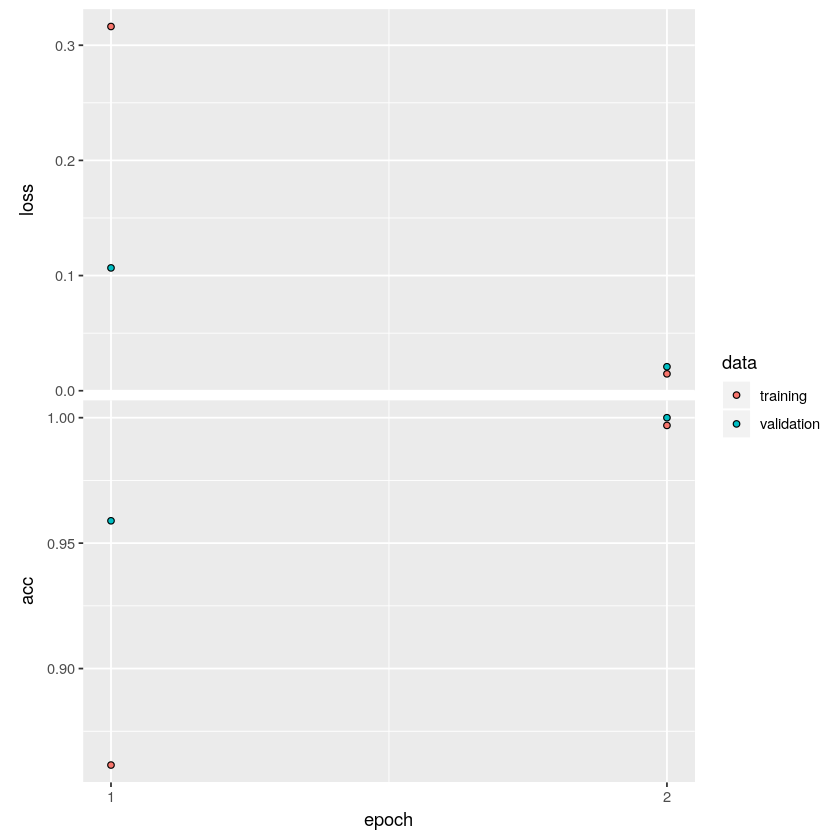

In [97]:
plot(history)

In [101]:
# make predictions on the validation data
preds = predict_generator(object = model_gen, 
                          steps = 3,
                          generator = validation_generator, 
                          verbose = 1)

In [99]:
# evaluate the results using the simple (and not optimal)
# accuracy measure provided by the evaluate_generator() function 
# for the validation generator
evaluate_generator(object = model_gen, 
                   generator = validation_generator, 
                   steps = 3,
                   workers = 1)


$loss
[1] 0.02084

$acc
[1] 1

## Sources

* [CRAN vignette for keras](https://cran.r-project.org/web/packages/keras/vignettes/getting_started.html)
* [Image manipulation in R with magick](https://cran.r-project.org/web/packages/magick/vignettes/intro.html)
* [Examples for keras in R](https://keras.rstudio.com/articles/examples/index.html)
* [Transfer learning with keras in R](https://cran.rstudio.com/web/packages/keras/vignettes/applications.html)
* [kaggle kernel on vgg16](https://www.kaggle.com/dkoops/keras-r-vgg16-base)
* [folder structure for the train generator](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)